In [1]:
import pandas as pd
from pathlib import Path
from salmon.triplets.samplers.adaptive._score import InfoGainScorer
from salmon.triplets.samplers.adaptive._noise_models import TSTE
import numpy as np
import salmon
import altair as alt
from time import time

## Setup

Read in the answers, and make an embedding from those answers (or read one saved on disk).

In [2]:
df = pd.read_csv("init-salmon/responses-out/random.csv")
n, d = 90, 2
N_ANS = 2 * 10 * n
df = df.iloc[:N_ANS]

assert df["head"].nunique() == n
hist = df[["head", "winner", "loser"]].to_numpy()
assert len(hist) == N_ANS
len(hist)

1800

In [3]:
from salmon.triplets.offline import OfflineEmbedding
import seaborn as sns

if False:
    offline = OfflineEmbedding(n=n, d=d)
    assert len(hist) == N_ANS
    X_train = hist
    X_test = hist
    offline.fit(X_train, X_test)
    em = offline.embedding_
    with open(f"io/_static_head-{N_ANS}.npy", "wb") as f:
        np.save(f, em)
else:
    with open(f"io/_static_head-{N_ANS}.npy", "rb") as f:
        em = np.load(f)

Show the embedding:

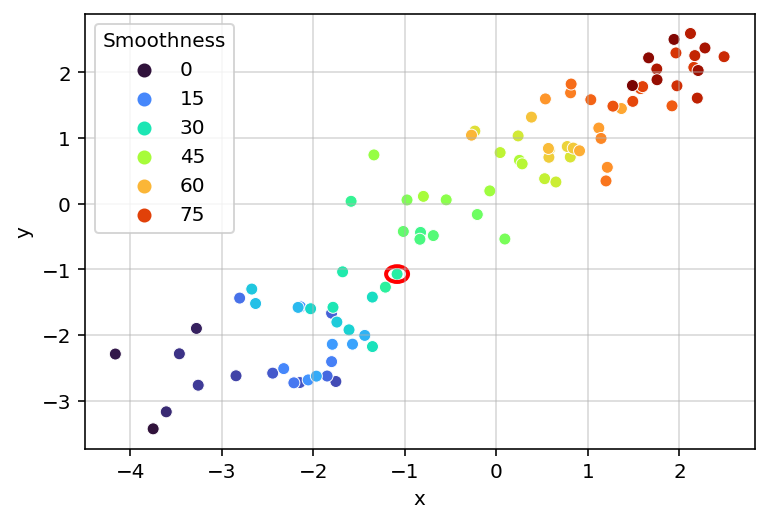

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

save_kwargs = dict(dpi=300, bbox_inches="tight", transparent=True)

def _show_em(em_show, ax):
    ax = sns.scatterplot(
        data=em_show,
        x="x", y="y", hue="index", palette="turbo",
        ax=ax,
    )

    heads = [32]
    for h in heads:
        loc = em_show.iloc[h][["x", "y"]]
        x, y = loc["x"], loc["y"]
        ax.add_patch(Circle((x, y), 0.12, fill=False, linewidth=2, color="red", linestyle="-"))
    ax.legend_.set_title("Smoothness")
    ax.grid(alpha=0.5)
    return ax

em_show = pd.DataFrame(em, columns=["x", "y"])
em_show["index"] = np.arange(len(em_show))
fig, ax = plt.subplots()
ax = _show_em(em_show, ax)
fig.savefig("figs4/search-em.png", **save_kwargs)

## Scoring queries

1. Make a list of queries.
2. Create information gain scorer.
3. Evaluate the information gain of each query.
4. Gather information on number of unique heads, and plot it:

Step 1:

In [8]:
_queries = np.array([
    [h, min(l, r), max(l, r)]
    for h in range(n) for l in range(n) for r in range(n)
    if h not in [l, r] and l != r
]).astype("int16")

_hashes = np.apply_along_axis(lambda x: hash(tuple(x)), 1, _queries)
_, idx = np.unique(_hashes, return_index=True)
_queries = _queries[idx]

Step 2:

In [9]:
est = TSTE(n=n, d=d)
ranker = InfoGainScorer(embedding=em, probs=est.probs)
ranker = ranker.push(hist)

In [11]:
len(hist)

1800

Step 3:

In [12]:
start = time()
queries, scores = ranker.score(queries=_queries)

low_high = np.argsort(scores)
high_low = np.flip(low_high)

print(f"Time taken: {time() - start:0.2f}s")
Q_before = queries[high_low[:849]]

Time taken: 3.97s


In [13]:
np.unique(queries[high_low[:10], 1:].flatten())

array([14, 18, 19, 21, 25, 26, 42, 45])

In [14]:
(queries[high_low[:3916], 0] == 32).mean()

0.5487742594484167

Step 4:

In [17]:
# def plot_repeated_queries(heads):
# return n_unique
heads = pd.Series(queries[high_low, 0])
n_q = 89 * 88 // 2
n_total = n_q * 90
data = []
fracs = np.logspace(-6, 0, num=10_000).tolist()
for frac in fracs:
    N = int(n_total * frac)
    if N < 1:
        N = 1
    datum = {"n_unique": heads.iloc[:N].nunique(), "n_top_queries": N}
    data.append(datum)

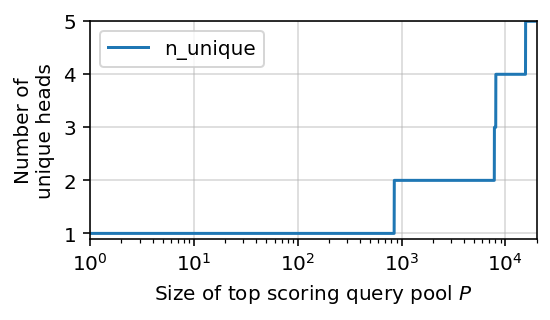

In [18]:
import matplotlib.pyplot as plt
show = pd.DataFrame(data)

w = 2
fig, ax = plt.subplots(figsize=(2 * w, w))
ax = show.plot(x="n_top_queries", y="n_unique", ax=ax)
ax.set_ylim(0.9, 35)
ax.set_xlim(1, 20_000)

ax.set_xscale("log")
ax.set_ylim(0.9, 5)
# ax.set_yscale("log", base=2)
# ax.set_xlim(1, 10 * n_q)
# n_q = 88 * 89 // 2
# ax.xaxis.set_major_locator(plt.MultipleLocator(n_q))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x // n_q)))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("Size of top scoring query pool $P$")
ax.set_ylabel("Number of\nunique heads")
ax.grid(alpha=0.5)
fig.savefig("figs4/top-N-queries.png", **save_kwargs)

Do some more investigation into the queries. Is one head selected to be the best?

In [20]:
n_q = 88 * 89 // 2  # number of queries for a single head
for N in [n_q, 2 * n_q, 5 * n_q, 10 * n_q]:
    r = pd.Series(queries[high_low[:int(N)], 0]).value_counts()
    print(r)

32    2149
35    1767
dtype: int64
32    3916
35    3916
dtype: int64
32    3916
34    3916
35    3916
38    3916
43    3916
dtype: int64
32    3916
34    3916
35    3916
36    3916
38    3916
43    3916
13    3916
85    3916
33    2951
42    2161
41    1489
45    1231
dtype: int64


In [21]:
len(hist)

1800

In [22]:
queries[high_low[:10]]

array([[32, 18, 42],
       [32, 18, 45],
       [32, 19, 42],
       [32, 26, 42],
       [32, 19, 45],
       [32, 26, 45],
       [32, 25, 42],
       [32, 25, 45],
       [32, 14, 42],
       [32, 21, 42]])

## Doing a model update with human-like responses

1. Define a noise model (determined from human responses).
2. Answer queries with that noise model:
3. Fit an embedding (and save to disk)
4. Visualize the embedding

Step 1:

In [24]:
import numpy as np
import pandas as pd
from sklearn.utils import check_random_state


def _sigmoid(x, err, rate):
    noiseless = 1 / (1 + np.exp(-rate * (x - 0.5)))
    p_correct = (1 - err * 2) * (noiseless - 0.5) + 0.5
    return p_correct


def alien_egg(h, l, r, random_state=None, err=0.07074231, rate=17.55473809) -> int:
    """
    Parameters
    ----------
    h, l, r : int, int, int
        Number of spikes on the various objects

    Returns
    -------
    winner : int
        0 if left wins, 1 if right wins

    Notes
    -----
    This is determined from human data.
    See datasets/alien-egg/alien-eggs-noise-model-n=30/Noise-model.ipynb for details.
    """
    ldiff = np.abs(h - l)
    rdiff = np.abs(h - r)

    r = np.maximum(ldiff, rdiff) / (ldiff + rdiff)
    p_correct = _sigmoid(r, err, rate)

    winner = 0 if ldiff < rdiff else 1
    random_state = check_random_state(random_state)
    if random_state.uniform() <= p_correct:
        return winner
    return 1 - winner

Step 2:

In [28]:
def _answer(h, l, r):
    winner = alien_egg(h, l, r)
    # 0 and 1 corresponds to l and r being winner respectively
    if winner == 0:
        return [h, l, r]
    return [h, r, l]
    
    
n_q = 88 * 89 // 2
print(n_q // 5)
_hist2 = [_answer(*q) for q in queries[high_low[:100]]]
print("Answering this many question:", len(_hist2))
print(len(hist))
hist2 = np.vstack((hist, _hist2))
print(len(hist2))

783
Answering this many question: 100
1800
1900


In [29]:
len(hist2)

1900

Step 3:

In [45]:
if False:
    offline = OfflineEmbedding(n=n, d=d, max_epochs=100_000, verbose=2000)
    assert len(hist2) == N_ANS + 100
    X_train = hist2
    X_test = hist2
    offline.fit(X_train, X_test, embedding=em.copy())
    em2 = offline.embedding_
    with open(f"io/_static_head-{N_ANS}-after.npy", "wb") as f:
        np.save(f, em2)
else:
    with open(f"io/_static_head-{N_ANS}-after.npy", "rb") as f:
        em2 = np.load(f)

Step 4:

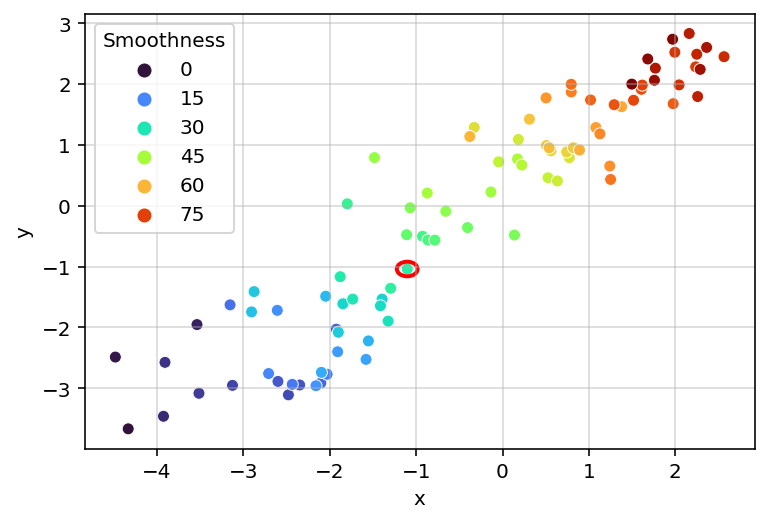

In [31]:
em_show2 = pd.DataFrame(em2, columns=["x", "y"])
em_show2["param"] = np.linspace(0, 1, num=n)
em_show2["index"] = np.arange(len(em_show2))
em_show2 = em_show2.reset_index()

fig, ax = plt.subplots()
ax = _show_em(em_show2, ax)
fig.savefig("figs4/search-em2.png", **save_kwargs)

## Rescore queries with new embedding

In [32]:
est2 = TSTE(n=n, d=d)
ranker2 = InfoGainScorer(embedding=em2, probs=est2.probs)
ranker2 = ranker.push(hist2)

In [33]:
start = time()
queries, scores = ranker2.score(queries=_queries)
print(f"Time taken: {time() - start:0.2f}s")

Time taken: 3.90s


In [34]:
low_high = np.argsort(scores)
high_low = np.flip(low_high)
queries[high_low[:10]]

array([[32, 28, 45],
       [32, 28, 42],
       [32, 21, 42],
       [32, 21, 45],
       [32, 26, 42],
       [32, 26, 45],
       [32, 25, 42],
       [32, 25, 45],
       [32, 21, 44],
       [32, 28, 41]])

In [35]:
Q_after = queries[high_low[:3916]]

In [36]:
np.unique(queries[high_low[:10], 1:].flatten())

array([21, 25, 26, 28, 41, 42, 44, 45])

In [37]:
Q2_after = {(h, w, l) for h, w, l in Q_after}
Q2_before = {(h, w, l) for h, w, l in Q_before}

In [38]:
(queries[high_low[:3918], 0] == 32).sum()

3916

In [39]:
len(Q2_before - Q2_after)

0

In [40]:
len(Q2_after - Q2_before)

3067

In [41]:
len(Q_before)

849

In [42]:
before =[(32, 18, 42),
(32, 18, 45),
(32, 19, 42),
(32, 26, 42),
(32, 19, 45),
(32, 26, 45),
(32, 25, 42),
(32, 25, 45),
(32, 14, 42),
(32, 21, 42)]

after = [(32, 22, 37),
       (32, 16, 37),
       (32, 27, 37),
       (32, 23, 40),
       (32, 22, 39),
       (32, 23, 39),
       (32, 16, 39),
       (32, 24, 40),
       (32, 22, 40),
       (32, 12, 40)]

set(before).intersection(set(after))
before_items = {i for q in before for i in q}
after_items = {i for q in after for i in q}
before_items.intersection(after_items)

{32}

In [43]:
for i in range(1, 10):
    H = queries[high_low[:i * n_q], 0]
    r = pd.Series(H).value_counts()
    print(r)

32    3916
dtype: int64
32    3916
33    3916
dtype: int64
32    3916
33    3916
35    3916
dtype: int64
32    3916
33    3916
35    3916
39    3892
42      16
34       8
dtype: int64
32    3916
33    3916
35    3916
39    3916
42    3051
34     858
38       7
dtype: int64
32    3916
33    3916
35    3916
39    3916
42    3916
34    2810
38    1106
dtype: int64
32    3916
33    3916
34    3916
35    3916
38    3916
39    3916
42    3916
dtype: int64
32    3916
33    3916
34    3916
35    3916
38    3916
39    3916
42    3916
40    2228
45    1671
1       17
dtype: int64
32    3916
33    3916
34    3916
35    3916
38    3916
39    3916
40    3916
42    3916
45    3885
1       31
dtype: int64


In [44]:
DL = np.abs(queries[:, 0] - queries[:, 1])
DR = np.abs(queries[:, 0] - queries[:, 2])
ratio = np.maximum(DL, DR) / (DL + DR)
ratio[:10]

array([0.5840708 , 0.87179487, 0.82142857, 0.72972973, 0.81034483,
       0.75      , 0.82      , 0.55384615, 0.72727273, 0.86363636])